# 1. 라이브러리 호출

In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms # 이미지 변환(전처리) 기능을 제공
from torch.autograd import Variable
from torch import optim # 경사하강법을 이용하여 가중치를 구하기 위한 옵티마이저
import os # 파일 경로에 대한 함수들을 제공
import cv2
from PIL import Image
from tqdm import tqdm_notebook as tqdm # 진행 상황 표현
import random
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/Users/song/opt/anaconda3/envs/python3811/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: dlopen(/Users/song/opt/anaconda3/envs/python3811/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <8E4D9E61-A0A3-30A7-B778-23E3E702B690> /Users/song/opt/anaconda3/envs/python3811/lib/python3.8/site-packages/torchvision/image.so
  Reason: tried: '/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/Users/song/opt/anaconda3/envs/python3811/lib/python3.8/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/song/opt/anaconda3/envs/p

# 2. 이미지 데이터셋 전처리

In [2]:
class ImageTransform():    
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]), ## 1
            'val': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }
        
    def __call__(self, img, phase): ## 2
        return self.data_transform[phase](img)

# 3. 이미지 데이터셋을 불러온 후 훈련, 검증, 테스트로 분리

In [3]:
cat_directory = './dogs-vs-cats/Cat/'
dog_directory = './dogs-vs-cats/Dog/'

## 1
cat_images_filepaths = sorted([os.path.join(cat_directory, f) 
                               for f in os.listdir(cat_directory)])   
dog_images_filepaths = sorted([os.path.join(dog_directory, f) 
                               for f in os.listdir(dog_directory)])
                               
## 2                               
images_filepaths = [*cat_images_filepaths, *dog_images_filepaths] 

## 3
correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None]    

random.seed(42) ## 4
random.shuffle(correct_images_filepaths)

# 일부 데이터만 사용
train_images_filepaths = correct_images_filepaths[:400]    
val_images_filepaths = correct_images_filepaths[400:-10]  
test_images_filepaths = correct_images_filepaths[-10:]    

print(len(train_images_filepaths), len(val_images_filepaths), len(test_images_filepaths))

400 92 10


# 4. 이미지 데이터셋 클래스 정의

In [4]:
class DogvsCatDataset(Dataset):
    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list
        self.transform = transform # DogvsCatDataset 클래스를 호출할 때 transform에 대한 매개변수를 받아 옵니다.
        self.phase = phase # train 적용

    def __len__(self): # images_filepaths 데이터셋의 전체 길이 반환
        return len(self.file_list)
    
    def __getitem__(self,idx): # 데이터셋에서 데이터를 가져오는 부분으로 결과는 텐서 형태 
        img_path = self.file_list[idx]
        img = Image.open(img_path) # img_path 위치에서 이미지 데이터들을 가져옴
        img_transformed = self.transform(img, self.phase) # 이미지에 'train' 전처리 적용
        label = img_path.split('/')[-1].split('.')[0] ## 1

        if label == 'dog':
            label = 1
        elif label == 'cat':
            label = 0
        return img_transformed, label

# 5. 변수 값 정의

In [5]:
# AlexNet은 깊이가 깊은 네트워크를 사용하므로 이미지 크기가 256이 아니면 폴링층 때문에 
# 크기가 계속 줄어들어 오류가 발생할 수 있습니다.

size = 256 
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32

# 6. 이미지 데이터셋 정의

In [6]:
train_dataset = DogvsCatDataset(train_images_filepaths, 
                                transform=ImageTransform(size,mean, std), 
                                phase='train') # train 이미지에 train_transforms를 적용
val_dataset = DogvsCatDataset(val_images_filepaths, 
                              transform=ImageTransform(size,mean, std), 
                              phase='val') # val 이미지에 train_transforms를 적용
test_dataset = DogvsCatDataset(val_images_filepaths, 
                                transform=ImageTransform(size, mean, std), 
                                phase='val')
                     
index = 0
print(train_dataset.__getitem__(index)[0].size()) # 훈련 데이터 train_dataset.__getitem__[0][0]의 크기(size) 출력
print(train_dataset.__getitem__(index)[1]) # 훈련 데이터의 레이블 출력

torch.Size([3, 256, 256])
0


# 7. 데이터로더 정의

In [7]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) ## 1
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# train_dataloader와 val_dataloader를 합쳐서 표현
dataloader_dict = {'train': train_dataloader, 'val': val_dataloader}

batch_iterator = iter(train_dataloader)
inputs, label = next(batch_iterator)
print(inputs.size())
print(label)

torch.Size([32, 3, 256, 256])
tensor([0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1,
        0, 1, 1, 0, 0, 0, 1, 0])


# 8. 모델의 네트워크 클래스

In [8]:
class AlexNet(nn.Module):
    def __init__(self) -> None:
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 2),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# 9. 모델 객체 생성

In [9]:
model = AlexNet()
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

# 10. 옵티마이저와 손실 함수 정의

In [10]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# 11. torchsummary 라이브러리를 이용한 모델의 네트워크 구조 확인

In [11]:
from torchsummary import summary
summary(model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 63, 63]          23,296
              ReLU-2           [-1, 64, 63, 63]               0
         MaxPool2d-3           [-1, 64, 31, 31]               0
            Conv2d-4          [-1, 192, 31, 31]         307,392
              ReLU-5          [-1, 192, 31, 31]               0
         MaxPool2d-6          [-1, 192, 15, 15]               0
            Conv2d-7          [-1, 384, 15, 15]         663,936
              ReLU-8          [-1, 384, 15, 15]               0
            Conv2d-9          [-1, 256, 15, 15]         884,992
             ReLU-10          [-1, 256, 15, 15]               0
           Conv2d-11          [-1, 256, 15, 15]         590,080
             ReLU-12          [-1, 256, 15, 15]               0
        MaxPool2d-13            [-1, 256, 7, 7]               0
AdaptiveAvgPool2d-14            [-1, 25

# 12. 모델 학습 함수 정의

In [12]:
def train_model(model, dataloader_dict, criterion, optimizer, num_epoch):    
    since = time.time()
    best_acc = 0.0
    
    for epoch in range(num_epoch):
        print('Epoch {}/{}'.format(epoch + 1, num_epoch))
        print('-'*20)
        
        for phase in ['train', 'val']:            
            if phase == 'train':
                model.train() # 모델을 학습시키겠다는 의미
            else:
                model.eval()
                
            epoch_loss = 0.0
            epoch_corrects = 0
            
            for inputs, labels in tqdm(dataloader_dict[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(preds == labels.data)
                    
            epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloader_dict[phase].dataset)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
   
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    return model

# 13. 모델 학습

In [14]:
import time

num_epoch = 10
model = train_model(model, dataloader_dict, criterion, optimizer, num_epoch)

Epoch 1/10
--------------------


/var/folders/l1/_bp5b7pn22q6_9bvlv0wq_kc0000gp/T/ipykernel_3857/585654950.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for inputs, labels in tqdm(dataloader_dict[phase]):


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6933 Acc: 0.4975


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6933 Acc: 0.4891
Epoch 2/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6931 Acc: 0.5200


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6933 Acc: 0.4891
Epoch 3/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6934 Acc: 0.4600


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6932 Acc: 0.5000
Epoch 4/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6932 Acc: 0.4825


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6932 Acc: 0.4783
Epoch 5/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6931 Acc: 0.4975


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6931 Acc: 0.5000
Epoch 6/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6931 Acc: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6931 Acc: 0.5109
Epoch 7/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6928 Acc: 0.5350


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6930 Acc: 0.5109
Epoch 8/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6934 Acc: 0.4925


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6929 Acc: 0.5109
Epoch 9/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6930 Acc: 0.5050


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6929 Acc: 0.5109
Epoch 10/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6932 Acc: 0.4900


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6929 Acc: 0.5109
Training complete in 2m 16s


# 16. 모델 테스트를 위한 함수 정의

In [17]:
import pandas as pd
id_list = []
pred_list = []
_id=0

# 역전파 중 텐서들에 대한 변화도를 계산할 필요가 없음을 나타내는 것으로, 훈련 데이터셋의 모델 학습과 가장 큰 차이점입니다.
with torch.no_grad(): 
    for test_path in tqdm(test_images_filepaths): # test 데이터셋 이용
        img = Image.open(test_path)
        _id =test_path.split('/')[-1].split('.')[1]
        transform = ImageTransform(size, mean, std)
        img = transform(img, phase='val') # test 데이터셋 전처리
        img = img.unsqueeze(0) ## 1
        img = img.to(device)

        model.eval()
        outputs = model(img)
        preds = F.softmax(outputs, dim=1)[:, 1].tolist() ## 2       
        id_list.append(_id)
        pred_list.append(preds[0])
       
res = pd.DataFrame({
    'id': id_list,
    'label': pred_list
}) # test 예측 결과인 Id와 레이블을 데이터 프레임에 저장

res.to_csv('LeNet.csv', index=False) # 데이터프레임을 csv 파일로 저장

/var/folders/l1/_bp5b7pn22q6_9bvlv0wq_kc0000gp/T/ipykernel_3857/3940014863.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for test_path in tqdm(test_images_filepaths): # test 데이터셋 이용


  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
class_ = classes = {0:'cat', 1:'dog'}
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        a = random.choice(res['id'].values)    
        label = res.loc[res['id'] == a, 'label'].values[0]
        if label > 0.5:
            label = 1
        else:
            label = 0
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(class_[label])
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

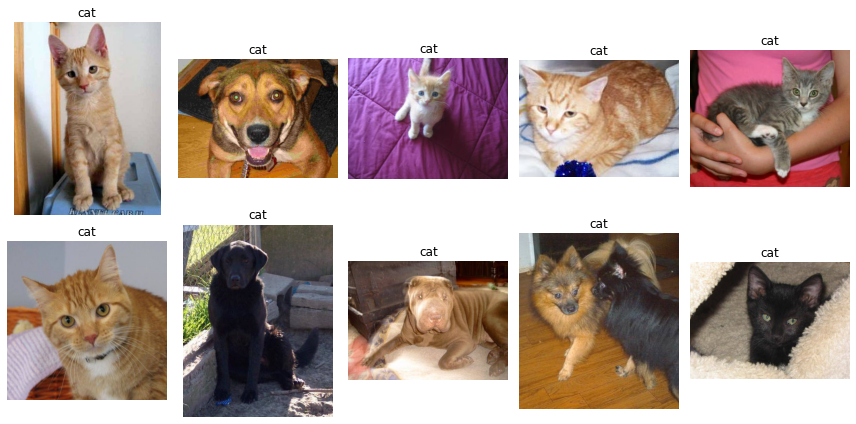

In [ ]:
display_image_grid(test_images_filepaths) 